In [1]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude("../Hofstadter Many Body Utils.ipynb")
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("Torus_Distance.ipynb");

In [97]:
Nx=10
Ny=10
p=1
q=10
par_num = 3
U = 2

N=Nx*Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [i for i in 1:par_num];

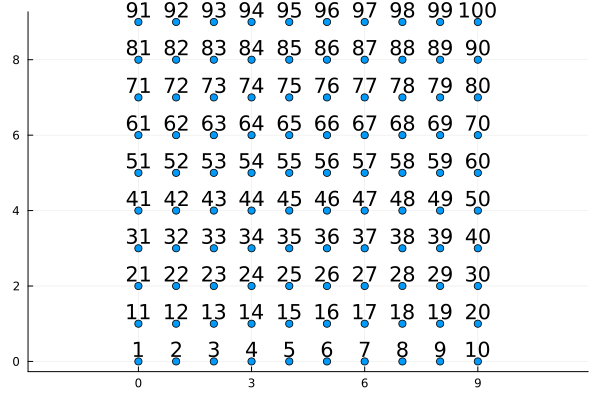

([0 0; 1 0; … ; 8 9; 9 9], nothing)

In [98]:
plot_square_lattice(Nx, Ny)

In [99]:
V_Strength = 4
V0 = [V_Strength, 
      V_Strength]
Imp_Site = [64, 27]
N_Pin = length(V0[V0 .> 0]) # Number of pinning quasihole
Impurity_Data = Impurity(V0, Imp_Site)
factor = 5; # particle density interpolation factor

0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
10.0%┣████▏                                     ┫ 1/10 [00:00<Inf:Inf, InfGs/it]
30.0%┣█████████████▉                                ┫ 3/10 [00:00<00:00, 15it/s]
50.0%┣███████████████████████                       ┫ 5/10 [00:00<00:00, 18it/s]
70.0%┣████████████████████████████████▏             ┫ 7/10 [00:00<00:00, 19it/s]
80.0%┣████████████████████████████████████▉         ┫ 8/10 [00:00<00:00, 19it/s]
90.0%┣█████████████████████████████████████████▍    ┫ 9/10 [00:00<00:00, 19it/s]
100.0%┣████████████████████████████████████████████┫ 10/10 [00:00<00:00, 19it/s]
100.0%┣████████████████████████████████████████████┫ 10/10 [00:00<00:00, 19it/s]
0.0%┣                                              ┫ 0/100 [00:00<00:00, -0s/it]
100.0%┣███████████████████████████████████████┫ 100/100 [00:00<00:00, 47.8kit/s]
100.0%┣███████████████████████████████████████┫ 100/100 [00:00<00:00, 46.6kit/s]


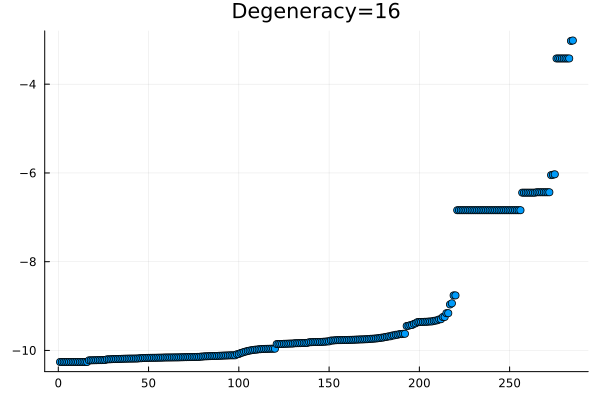

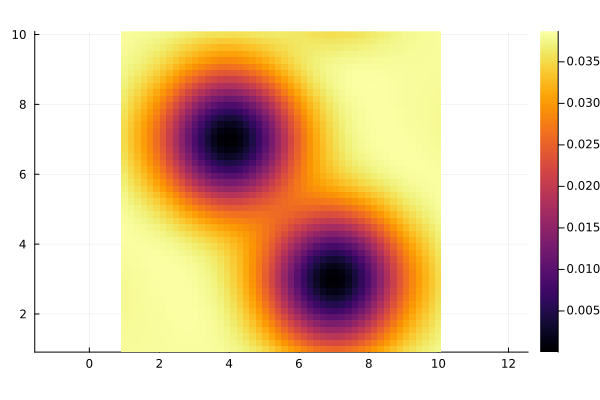

In [100]:
E, Sub_Number_MB_Operator_List, basis_cut_mb, Degeneracy, Total_H, Sub_Number_MB_Operator_List, r_hubbard_states,pn, NPhi0 = Get_MB(N, Nx, Ny, p, q, cut_off, PN, U, Impurity_Data);

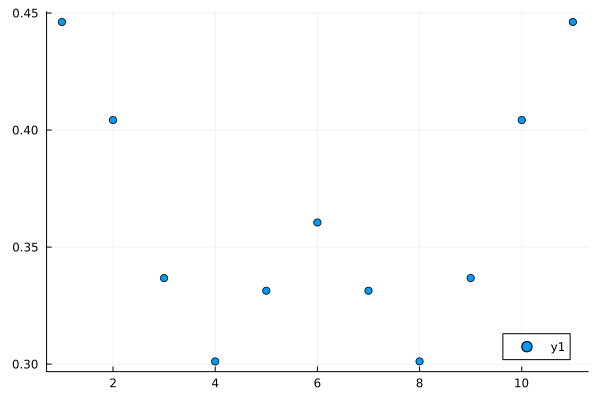

In [101]:
scatter(sum(avg_density,dims=2),dims=1)

In [102]:
# Torus Distance and Equivalent (Periodic) Sites
@nbinclude("Torus_Distance.ipynb");

In [103]:
coordinates, latticee = get_square_lattice(Nx, Ny)
coordinates_top_left, coordinates_top, coordinates_top_right, coordinates_left, coordinates_right, coordinates_bottom_left, coordinates_bottom, coordinates_bottom_right, co_districts = get_ghost_sites(coordinates)
ref_coordinates = coordinates
ref_site = Imp_Site[2] # Site Pinned (Site 44 = Site 36) for Inner_Sites function (It's not general form)
# GÜNCELLEME: Inner_Sites -> Inner_Sites2 (General Form)
radius_list = get_radii(ref_coordinates, coordinates, ref_site, N);

In [104]:
All_Coordinates, X_Coordinates, Y_Coordinates, All_Coordinates_2 = get_all_sites(Nx, Ny, coordinates);

In [105]:
# Hangi siteler, ilgili yarı-çap içerisinde, şartını kontrol ediyoruz
function Inner_Sites(Radius)
    
    ref_district = coordinates # Center Distrinct
    Ref_Site_X = ref_district[:,1][ref_site]
    Ref_Site_Y = ref_district[:,2][ref_site]
    
    inner_sites = []
    
    for i in 1:Nx*Ny*9
        
        if (X_Coordinates[i] - Ref_Site_X)^2 + (Y_Coordinates[i] - Ref_Site_Y)^2 < (Radius+0.1)^2
            
            # Yarı-çap büyüdüğünde, periyodik noktalara sıçrayınca, "get_eq_site" fonksiyonu ile eş-değer siteleri buluyoruz.
            push!(inner_sites, get_eq_site(X_Coordinates[i], Y_Coordinates[i]))
        end
    end
    
    return inner_sites
end

Inner_Sites (generic function with 1 method)

In [106]:
coords = get_coords_square(Nx, Ny);

In [107]:
function Inner_Sites2(Radius,ref_site,coords)
    
    inner_sites = []
    
    for i in 1:Nx*Ny
        
        Δx = abs(coords[i][1] - coords[ref_site][1])
        Δx = min(Δx,mod(-Δx,Nx-1)+1)

        Δy = abs(coords[i][2] - coords[ref_site][2])
        Δy = min(Δy,mod(-Δy,Ny-1)+1)
        
        if Δx^2 + Δy^2 <= (Radius)^2
            push!(inner_sites, i)
        end
        
    end
    
    return inner_sites
end

Inner_Sites2 (generic function with 1 method)

In [108]:
ref_site

27

In [109]:
Radius = 3
Inner_Sites2(Radius,ref_site,coords)

29-element Vector{Any}:
  5
  6
  7
  8
  9
 15
 16
 17
 18
 19
 24
 25
 26
  ⋮
 35
 36
 37
 38
 39
 45
 46
 47
 48
 49
 57
 97

In [110]:
function get_depletion_prof(radius_list,ref_site,coords,avg_density)
    S_list = []
    for Radius in radius_list
        S = 0
        for i in Inner_Sites2(Radius,ref_site,coords)
            S+=ref_par_density.-avg_density[(coords[i].+1)...]
        end
        push!(S_list, S)
    end
    return S_list
end

get_depletion_prof (generic function with 1 method)

In [111]:
get_depletion_prof(radius_list,ref_site,coords,avg_density)

33-element Vector{Any}:
 0.03417773561547737
 0.14505527695409598
 0.23495574521583082
 0.29295874466368665
 0.3893386113941564
 0.4209676274327014
 0.4391045160354116
 0.4767922504917225
 0.4767922504917225
 0.524832074610961
 0.5366818769432585
 0.5366818769432585
 0.6219499938056241
 ⋮
 0.8793908344366324
 0.8793908344366324
 0.8793908344366324
 0.8906175529202953
 0.8906175529202953
 0.8906175529202953
 0.8906175529202953
 0.8906175529202953
 0.8906175529202953
 0.8906175529202953
 0.8906175529202953
 0.8906175529202953

In [112]:
radius_list

33-element Vector{Any}:
 0.0
 1.0
 1.4142135623730951
 2.0
 2.23606797749979
 2.8284271247461903
 3.0
 3.1622776601683795
 3.605551275463989
 4.0
 4.123105625617661
 4.242640687119285
 4.47213595499958
 ⋮
 6.4031242374328485
 6.708203932499369
 7.0
 7.0710678118654755
 7.211102550927978
 7.280109889280518
 7.615773105863909
 7.810249675906654
 8.06225774829855
 8.48528137423857
 8.602325267042627
 9.219544457292887

In [127]:
ref_par_density = (pn*p/q)/((NPhi0-N_Pin))
# Burada NPhi0=Nphi

0.0375

In [115]:
function get_depletion_profile_old(radius_list, avg_density)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites(i)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((ref_par_density .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile_old (generic function with 1 method)

In [116]:
function get_depletion_profile2(radius_list, avg_density, ref_site,coords)
    
    density_list_1 = []
    density_list_2 = []
    depletion_prof = []
    
    for i in radius_list
        
        summ = 0
    
        for j in Inner_Sites2(i,ref_site,coords)
            
            # r içindeki her bir sitenin ortalama yoğunluğu 
            push!(density_list_1, collect(Iterators.flatten((ref_par_density .- avg_density|>transpose)))[j])
            # Örgüde sadece bir tane quasi-parçacık boştayken gelen neredeyse ortalama yoğunluk 3/70'tir!
            
            # aynı yoğunluklar gelirse sadece onların birisini tut
            density_list_2 = unique!(density_list_1)
            
            # her biri biricik ve her bir site için olan yoğunlukları topla
            summ = sum(density_list_2)
        end
        
        # Sitelerin toplam yoğunluklarını bir listede her bir yarı-çap için biriktir
        push!(depletion_prof, summ)
    end
    
    return depletion_prof
end

get_depletion_profile2 (generic function with 1 method)

In [117]:
avg_density = Get_Avg_Density(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, r_hubbard_states);

\begin{align*}
&Q_{\rho} = \sum_i \left(<n_i>_{V=0}-<n_i>_{V \neq 0} \right) \\
&\text{Isotropic (uniform) reference particle density:}<n_i>_{V=0} \\
&<n_i>_{V=0} \approx \frac{N \alpha}{(N_\phi-N_{pin})} = \frac{3}{70}, \text{where } N_{pin}=1  \\
&Q=\frac{N}{N_\phi-1}=\frac{3}{7}
\end{align*}

In [118]:
depletion_prof = get_depletion_profile(radius_list, avg_density)

33-element Vector{Any}:
 0.0285366754080493
 0.121226888223175
 0.19585390556864066
 0.24401559559223115
 0.31989306950775975
 0.3394556457880096
 0.3531643263567882
 0.3757267589692301
 0.39881754456617685
 0.3982161935267717
 0.4014981057533746
 0.4249854825476235
 0.45213678533177876
 ⋮
 0.6910109320634106
 0.6910109320634106
 0.71250047999271
 0.71250047999271
 0.71250047999271
 0.71250047999271
 0.71250047999271
 0.71250047999271
 0.71250047999271
 0.71250047999271
 0.71250047999271
 0.71250047999271

In [119]:
sum(ref_par_density.-avg_density)

0.7500000000000004

In [120]:
depletion_prof2 = get_depletion_profile2(radius_list, avg_density, ref_site,coords)

33-element Vector{Any}:
 0.0285366754080493
 0.121226888223175
 0.19585390556864066
 0.24401559559223115
 0.31989306950775975
 0.3394556457880096
 0.3531643263567882
 0.37572675896923013
 0.37572675896923013
 0.39821619352677173
 0.40149810575337463
 0.40149810575337463
 0.4521367853317788
 ⋮
 0.6910109320634107
 0.6910109320634107
 0.6910109320634107
 0.7125004799927102
 0.7125004799927102
 0.7125004799927102
 0.7125004799927102
 0.7125004799927102
 0.7125004799927102
 0.7125004799927102
 0.7125004799927102
 0.7125004799927102

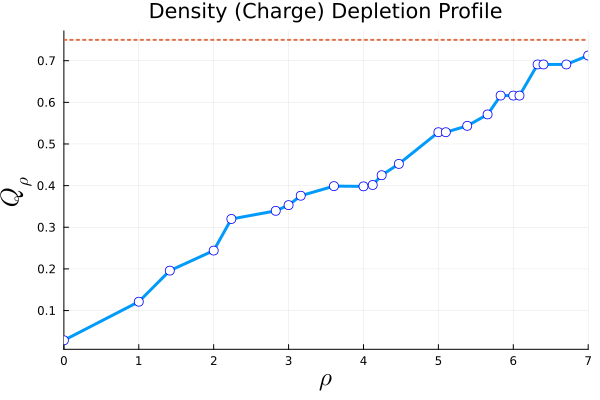

In [121]:
#xticks=0:1:12, yticks=0:0.10:0.46, 
Plots.plot(radius_list, depletion_prof, xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, m = (5, :white, stroke(1, :blue)))
Q = 2*pn/(NPhi-2)
g(x)=Q; x=0
Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,7))

In [124]:
Q

0.75

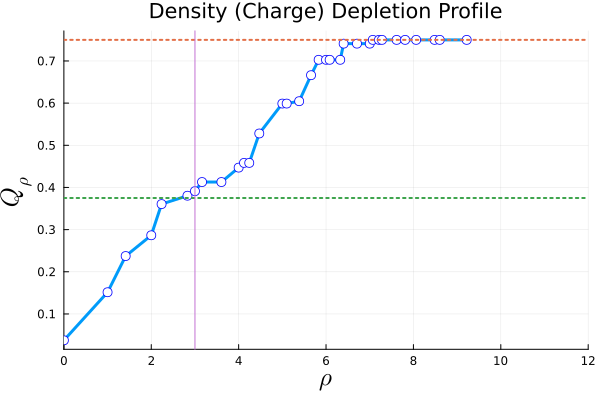

In [122]:
#xticks=0:1:12, yticks=0:0.10:0.46, 
Plots.plot(radius_list, get_depletion_prof(radius_list,ref_site,coords,avg_density), xlabel=L"\rho", ylabel=L"Q_{\rho}", title="Density (Charge) Depletion Profile", guidefontsize=17,legend=false, linewidth=3, m = (5, :white, stroke(1, :blue)))
Q = 2*pn/(NPhi-2)
g(x)=Q; x=0
f(x)=Q/2
Plots.plot!(g, x, length(radius_list), line=(:dot,2), xlim=(0,12))
Plots.plot!(f, x, length(radius_list), line=(:dot,2), xlim=(0,12))
plot!([3], seriestype="vline", label="")

In [123]:
# NOT quasi particle sadece örgü merkezinde iken yük hesabı doğru. Bunu genelleştirmek lazım!

In [190]:
# GÜNCELLEME: Eş-değer siteleri mod ile seçince, quasiparticle merkezde olmaması sorunu ortadan kalkmadı!